In [1]:
import os
import numpy as np
from glob import glob

## to do list:
1. create validation set and sample set
2. move to separate dirs for each set
3. finetune and train
4. submit

# Create validation set and sample set

In [2]:
%pwd

u'/home/hsgui/repo/nbs'

In [3]:
%cd data/dogs-vs-cats-redux-kernels-edition/

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition


In [4]:
%cd train/

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition/train


In [5]:
g = glob('*.jpg')
shu = np.random.permutation(g)
for i in range(2000): os.rename(shu[i], '../valid/' + shu[i])

In [6]:
%mkdir ../sample/train
%mkdir ../sample/valid

mkdir: cannot create directory ‘../sample/train’: File exists
mkdir: cannot create directory ‘../sample/valid’: File exists


In [7]:
from shutil import copyfile

In [8]:
g = glob('*.jpg')
shu = np.random.permutation(g)
for i in range(200): copyfile(shu[i], '../sample/train/' + shu[i])

In [9]:
%cd ../valid

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition/valid


In [10]:
g = glob('*.jpg')
shu = np.random.permutation(g)
for i in range(50): copyfile(shu[i], '../sample/valid/' + shu[i])

# Move to separate dirs for each set

In [17]:
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

In [12]:
%cd ../train

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition/train


In [14]:
%cd ../sample/train

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition/sample/train


In [16]:
%cd ../valid

/home/hsgui/repo/nbs/data/dogs-vs-cats-redux-kernels-edition/sample/valid


In [20]:
%cd ../../

/home/hsgui/repo/nbs


# Finetune and train

In [2]:
from vgg16 import Vgg16

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [3]:
vgg = Vgg16()

In [4]:
path = 'data/dogs-vs-cats-redux-kernels-edition/'

In [5]:
batch_size = 32

In [25]:
batches = vgg.get_batches(path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)
vgg.finetune(batches)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [26]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 1111s - loss: 0.1369 - acc: 0.9675 - val_loss: 0.0882 - val_acc: 0.9835


In [29]:
vgg.model.save_weights(path+'results/ft1.h5')

# Run more epochs

In [101]:
batches = vgg.get_batches(path + 'train', batch_size=batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [103]:
vgg.finetune(batches)

In [104]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 1071s - loss: 0.1271 - acc: 0.9697 - val_loss: 0.0724 - val_acc: 0.9850


In [105]:
vgg.model.save_weights(path + 'results/ft2.h5')

In [106]:
vgg.model.optimizer.lr = 0.01

In [107]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 1071s - loss: 0.1276 - acc: 0.9758 - val_loss: 0.0675 - val_acc: 0.9845


In [108]:
vgg.model.save_weights(path + 'results/ft3.h5')

# Submit

In [112]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size * 2)

Found 12500 images belonging to 1 classes.


In [113]:
filenames = batches.filenames

In [114]:
filenames[:5]

['unknown/160.jpg',
 'unknown/1138.jpg',
 'unknown/1470.jpg',
 'unknown/7901.jpg',
 'unknown/5291.jpg']

In [115]:
preds[:5]

array([[  7.2048e-19,   1.0000e+00],
       [  1.0000e+00,   1.0904e-17],
       [  1.0151e-16,   1.0000e+00],
       [  3.7327e-15,   1.0000e+00],
       [  8.2112e-08,   1.0000e+00]], dtype=float32)

In [36]:
from utils import *;

In [116]:
save_array(path+'results/test_preds.dat', preds)
save_array(path + 'results/filenames.dat', filenames)

In [38]:
preds = load_array(path+'results/test_preds.dat')
filenames = load_array(path + 'results/filenames.dat')

In [39]:
from PIL import Image

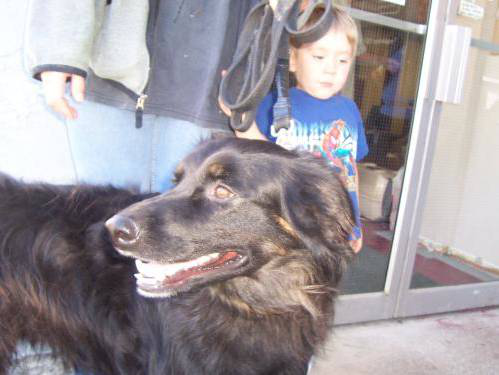

In [41]:
Image.open(path + 'test/' + filenames[0])

In [117]:
isdogs = preds[:, 1]

In [118]:
isdogs[:5]

array([  1.0000e+00,   1.0904e-17,   1.0000e+00,   1.0000e+00,   1.0000e+00], dtype=float32)

In [122]:
isdogs_clip = isdogs.clip(min=0.05, max=0.95)
isdogs_clip[:5]

array([ 0.95,  0.05,  0.95,  0.95,  0.95], dtype=float32)

In [123]:
ids = [int(f[8:f.find('.')]) for f in filenames]

In [124]:
ids[:5]

[160, 1138, 1470, 7901, 5291]

In [125]:
subm = np.stack([ids, isdogs], axis=1)

In [126]:
subm[:5]

array([[  1.6000e+02,   1.0000e+00],
       [  1.1380e+03,   1.0904e-17],
       [  1.4700e+03,   1.0000e+00],
       [  7.9010e+03,   1.0000e+00],
       [  5.2910e+03,   1.0000e+00]])

In [127]:
np.savetxt(path + 'submit98_3.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [128]:
from IPython.display import FileLink

In [130]:
FileLink(path + 'submit98_3.csv')

/home/hsgui/repo/deeplearning-projects/data/dogs-vs-cats-redux-kernels-edition/submit98_3.csv

# Validate the predictions

In [111]:
vgg.model.load_weights(path + 'results/ft3.h5')

In [7]:
valid_batches, preds = vgg.test(path + 'valid/', batch_size)

Found 2000 images belonging to 2 classes.


In [10]:
filenames = valid_batches.filenames
expected_labels = valid_batches.classes

In [11]:
filenames[:5],expected_labels[:5]

(['cats/cat.10518.jpg',
  'cats/cat.1716.jpg',
  'cats/cat.8797.jpg',
  'cats/cat.12420.jpg',
  'cats/cat.4777.jpg'],
 array([0, 0, 0, 0, 0], dtype=int32))

In [12]:
preds[:5]

array([[  1.00000000e+00,   8.24975331e-12],
       [  1.00000000e+00,   9.10426181e-14],
       [  1.00000000e+00,   2.69030007e-11],
       [  9.99758184e-01,   2.41805246e-04],
       [  1.00000000e+00,   1.93928365e-16]], dtype=float32)

In [13]:
our_predictions = preds[:, 0]
our_labels = np.round(1-our_predictions)

In [15]:
our_predictions[:5], our_labels[:5]

(array([ 1.        ,  1.        ,  1.        ,  0.99975818,  1.        ], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.], dtype=float32))

In [51]:
from keras.preprocessing import image
from utils import *
%matplotlib inline

In [45]:
def plot_idx(idx, titles = None):
    valid_path = path + 'valid/'
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles = titles)

In [19]:
n_view = 6

### a few correct labels at random

In [22]:
# https://stackoverflow.com/questions/34667282/numpy-where-detailed-step-by-step-explanation-examples
corrects = np.where(expected_labels == our_labels)

In [23]:
corrects = corrects[0]

In [48]:
print("found %d correct labels" % len(corrects))
corrects[:5]

found 1967 correct labels


array([0, 1, 2, 3, 4])

[1850 1913 1779  316  815  208]


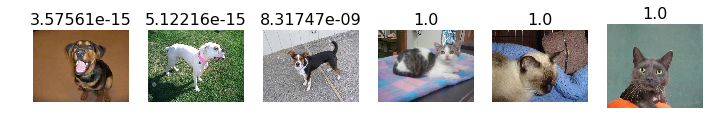

In [52]:
idx = np.random.permutation(corrects)[:n_view]
print(idx)
plot_idx(idx, our_predictions[idx])

### a few incorrect labels at random

In [53]:
incorrects = np.where(expected_labels != our_labels)
incorrects = incorrects[0]

In [54]:
print "found %d incorrect lables" % len(incorrects)
incorrects[:5]

found 33 incorrect lables


array([  6,   8,  11,  49, 127])

[ 127  401 1424 1318  833 1040]


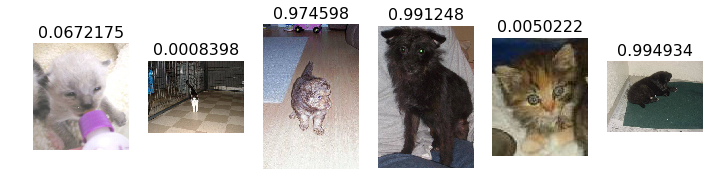

In [56]:
idx = np.random.permutation(incorrects)[:n_view]
print(idx)
plot_idx(idx, our_predictions[idx])

### the images that we have high confident they are cats, and they are really cats

found 938 confident cat labels and they are really cats
[744 934 910 686 333 463]


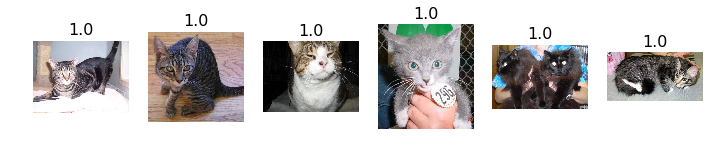

In [74]:
correct_cats = np.where((our_labels == 0) & (our_labels == expected_labels))[0]
print "found %d confident cat labels and they are really cats" % len(correct_cats)
idx = np.random.permutation(correct_cats)[:n_view]
print idx
plot_idx(idx, our_predictions[idx])

[ 175  310 1034  135  288  517]


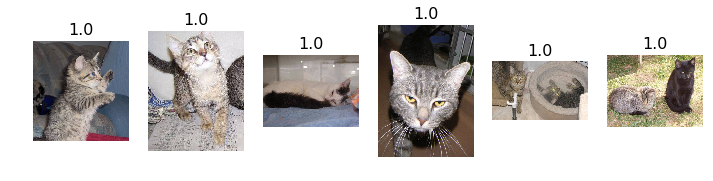

In [67]:
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
print idx
plot_idx(correct_cats[most_correct_cats], our_predictions[correct_cats[most_correct_cats]])

### the images that we have high confident they are dogs, and they are really dogs

Found 1029 confident dog labels and they are really dogs
[ 175  310 1034  135  288  517]


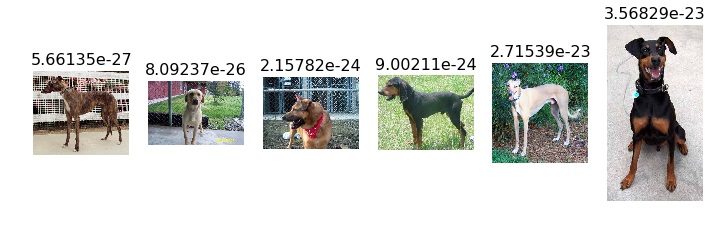

In [73]:
correct_dogs = np.where((our_labels == 1) & (our_labels == expected_labels))[0]
print "Found %d confident dog labels and they are really dogs" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
print idx
plot_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs[most_correct_dogs]])

### the images that we have high confident they are cats, but they are actually dogs

found 11 confident cat labels but they are actually dogs


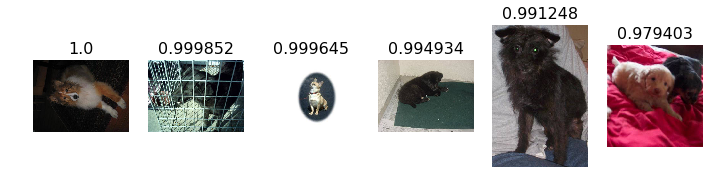

In [72]:
incorrect_cats = np.where((our_labels == 0) & (our_labels != expected_labels))[0]
if len(incorrect_cats):
    print "found %d confident cat labels but they are actually dogs" % len(incorrect_cats)
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plot_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats[most_incorrect_cats]])

### the images that we have high confident they are dogs, but they are actually cats

found 22 confident dogs but they are actually cats


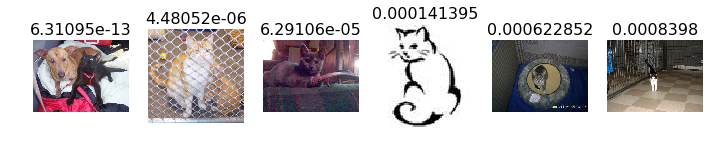

In [75]:
incorrect_dogs = np.where((our_labels == 1) & (our_labels != expected_labels))[0]
if len(incorrect_dogs):
    print "found %d confident dogs but they are actually cats" % len(incorrect_dogs)
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plot_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs[most_incorrect_dogs]])

### most uncertain

[ 0.5     0.5     0.5     0.4998  0.5   ]


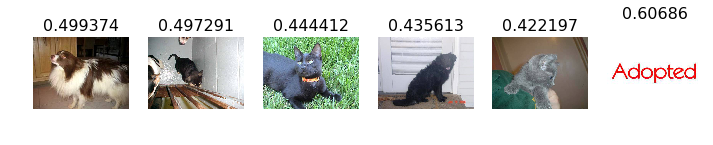

In [82]:
shift = np.abs(0.5 - our_predictions)
print shift[:5]
most_uncertain = np.argsort(shift)[:n_view]
plot_idx(most_uncertain, our_predictions[most_uncertain])

## Confusion matrix
see: http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/

In [83]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[ 938   22]
 [  11 1029]]


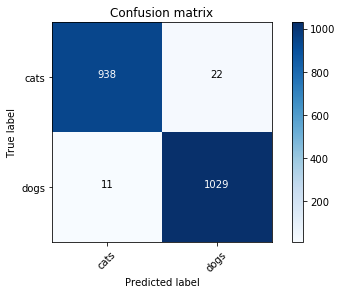

In [84]:
plot_confusion_matrix(cm, valid_batches.class_indices)

## Trick regards with Log Loss

In [85]:
preds = load_array(path + 'results/test_preds.dat')
filenames = load_array(path + 'results/filenames.dat')

In [86]:
isdogs = preds[:, 1]
print isdogs[:5]

[  1.0000e+00   2.8174e-15   1.0000e+00   1.0000e+00   1.0000e+00]


In [95]:
clip_isdogs = isdogs.clip(min=0.05, max=0.85)

In [96]:
clip_isdogs[:5]

array([ 0.9,  0.1,  0.9,  0.9,  0.9], dtype=float32)

In [90]:
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [91]:
ids[:5]

array([ 160, 1138, 1470, 7901, 5291])

In [98]:
subm = np.stack([ids, clip_isdogs], axis = 1)
subm[:5]

array([[  1.6000e+02,   9.0000e-01],
       [  1.1380e+03,   1.0000e-01],
       [  1.4700e+03,   9.0000e-01],
       [  7.9010e+03,   9.0000e-01],
       [  5.2910e+03,   9.0000e-01]])

In [99]:
np.savetxt(path + 'submit98_clip.csv', subm, fmt='%d,%.5f', header='id,label', comments='')

In [100]:
from IPython.display import FileLink
FileLink(path + 'submit98_clip.csv')

/home/hsgui/repo/deeplearning-projects/data/dogs-vs-cats-redux-kernels-edition/submit98_clip.csv